In [5]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Shin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [41]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import re
import string
import nltk
from nltk.corpus import stopwords
import seaborn as sns
import matplotlib.pyplot as plt
from textblob import TextBlob
from plotly.offline import iplot
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
from wordcloud import WordCloud,STOPWORDS
import itertools

In [29]:
df_love = pd.read_csv(r'C:\Users\Shin\Documents\UM\UM\Year 2 Sem 2\WID3006 Machine Learning\Assignment\love.csv')
df_nonlove = df_love.loc[df_love['labels'] == 0]
df_onlylove = df_love.loc[df_love['labels'] == 1]

,text,labels
0,"My Dearest Friend, should I draw you the pictu...",1
5,"Our love will bloom always fairer, fresher, mo...",1
6,I have a thousand images of you in an hour; al...,1
11,Fräulein Felice! I am now going to ask you a f...,1
14,There would have been the making of an accompl...,1
...,...,...
8188,You bring smiles to my face and joy to my hear...,1
8189,The best thing about being in love with you is...,1
8190,Even a doctor would be baffled at how my heart...,1
8191,You evoke happy emotions in me; you surface th...,1


In [7]:
clean_letter=df_love.copy()

In [8]:
def review_cleaning(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [9]:
clean_letter['text'] = clean_letter['text'].apply(lambda x:review_cleaning(x))
stop = stopwords.words('english')
clean_letter['text'] = clean_letter['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
clean_letter

,text,labels
0,dearest friend draw picture heart would hope w...,1
1,u going ikea str aft dat,0
2,think reading book first spoils movie shining ...,0
3,crap tomorrow time tee time hahaha exclusive d...,0
4,didt play one day last year know even though g...,0
...,...,...
8188,bring smiles face joy heart make happy youre t...,1
8189,best thing love begun enjoy every season life ...,1
8190,even doctor would baffled heart conveniently d...,1
8191,evoke happy emotions surface beautiful feeling...,1


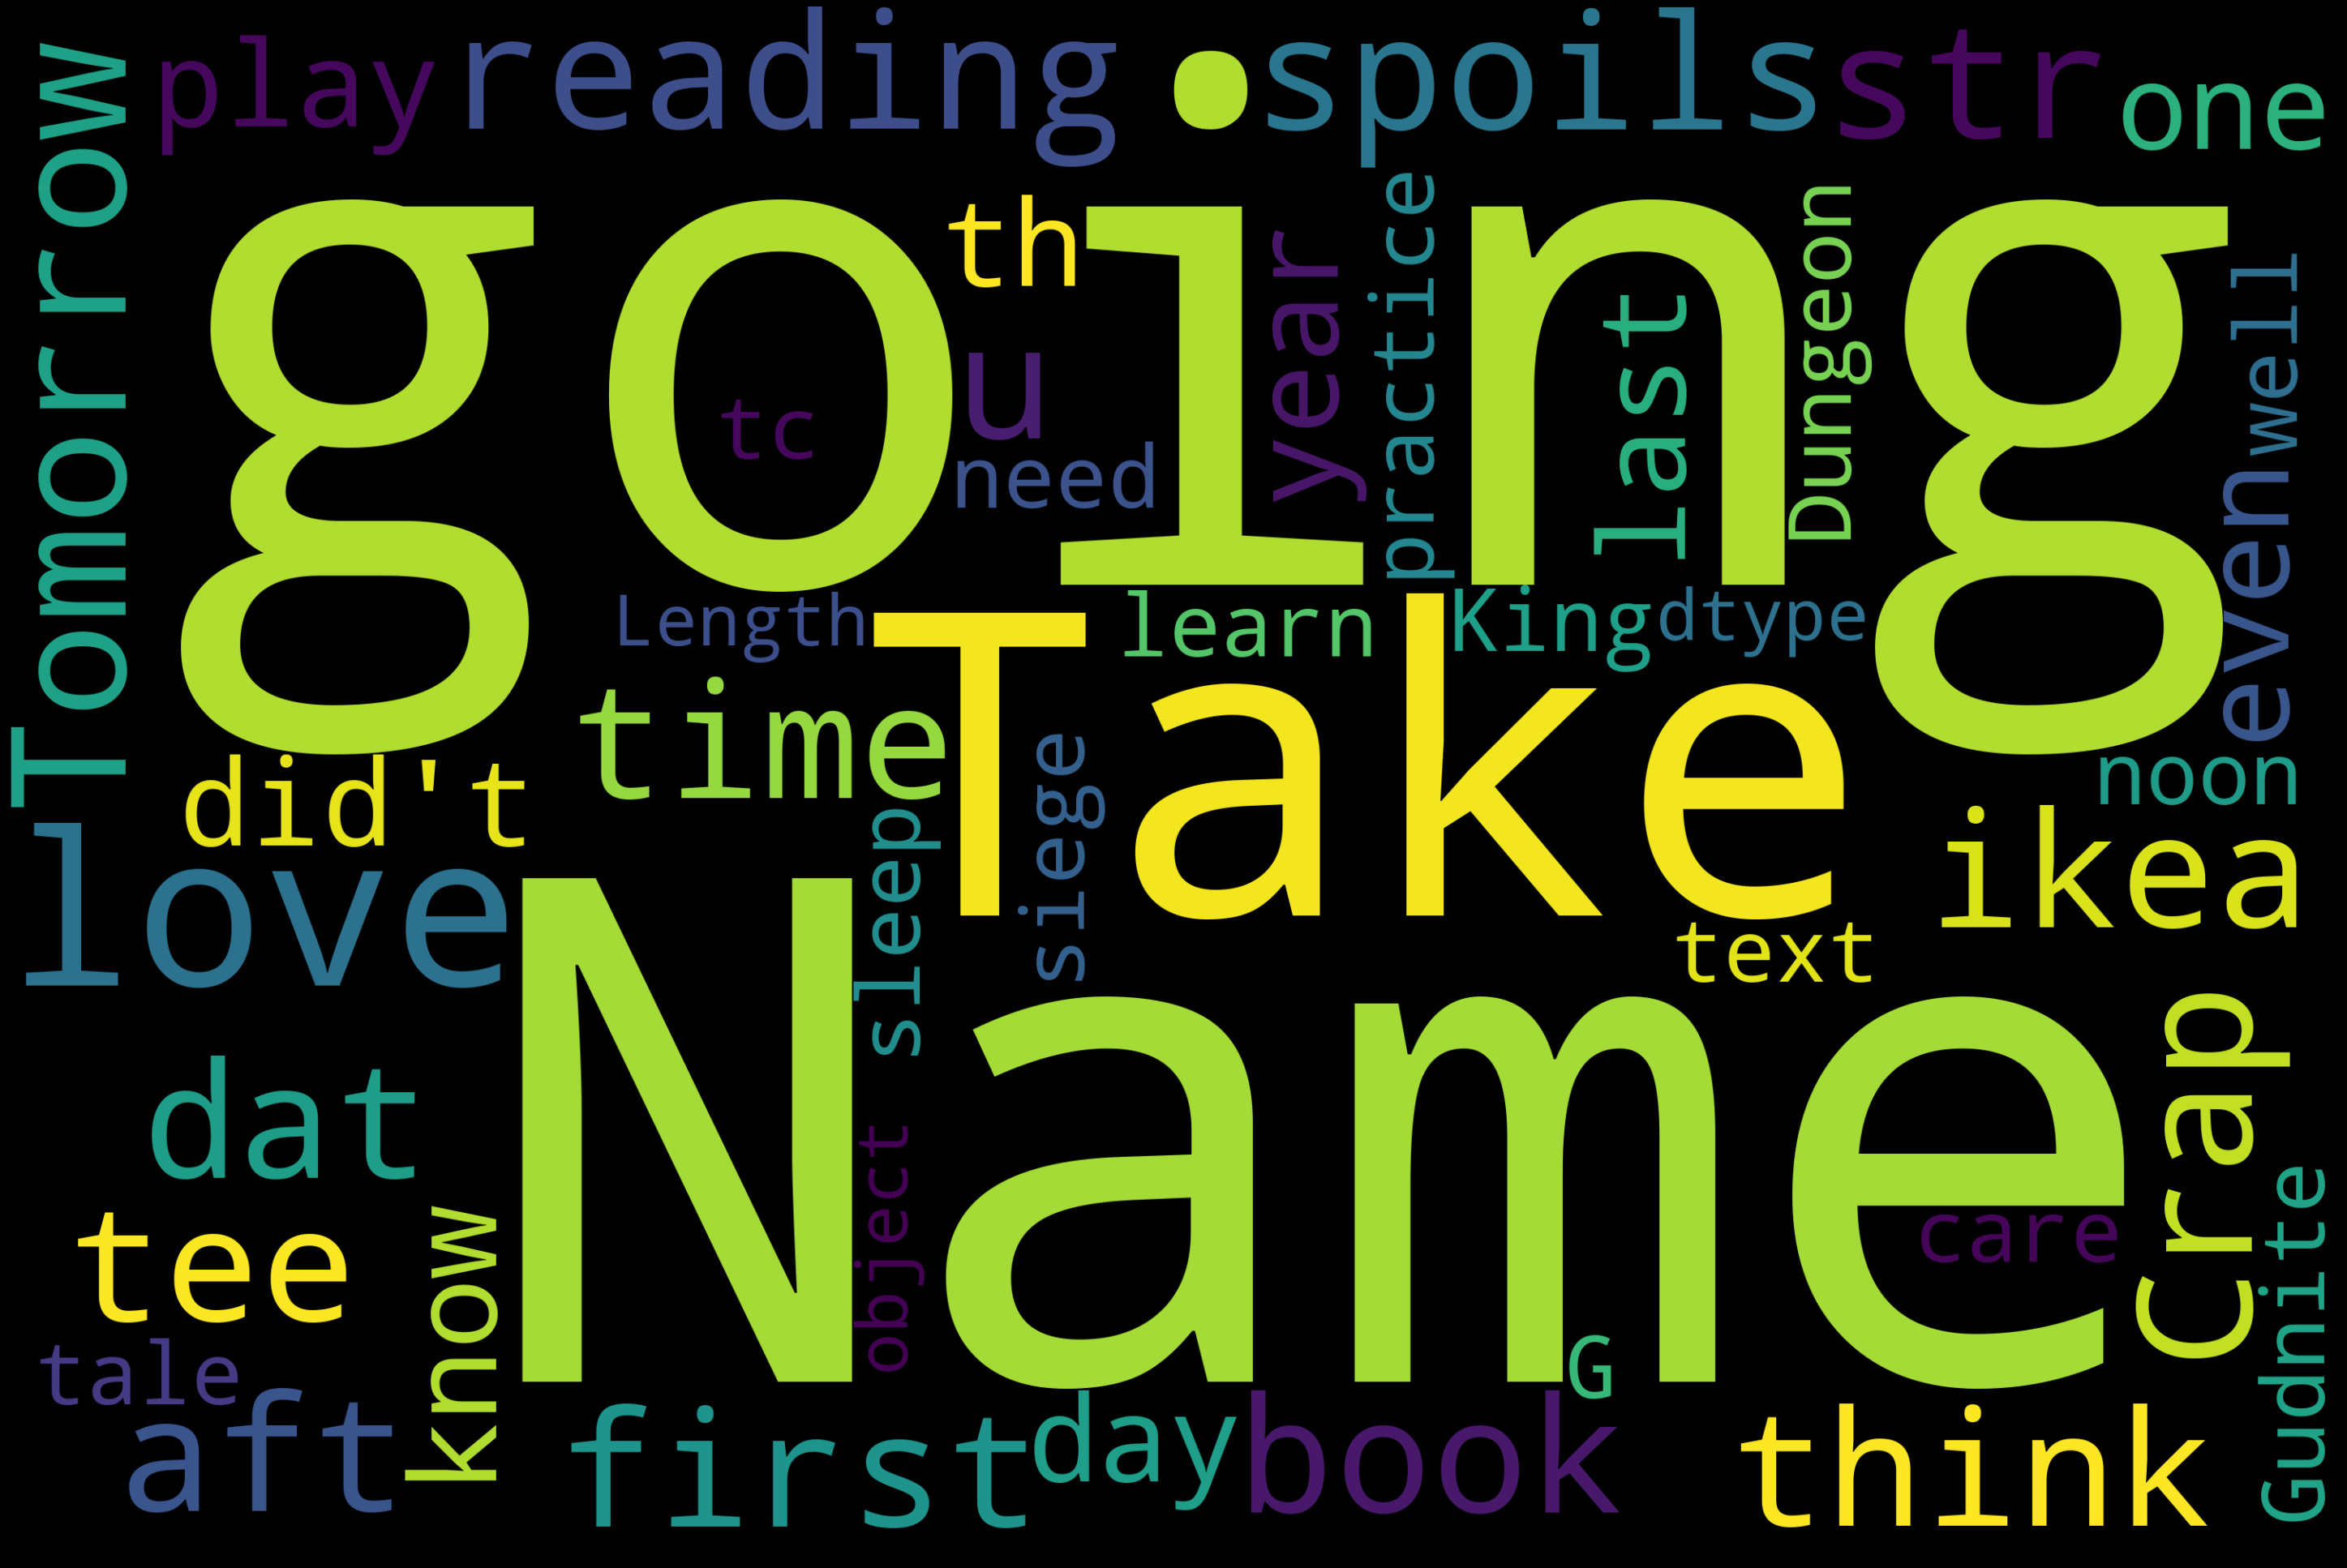

In [33]:
text = df_nonlove["text"]
wordcloud = WordCloud(width = 3000, height = 2000, background_color = 'black', stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(figsize = (40, 30), facecolor = 'k', edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

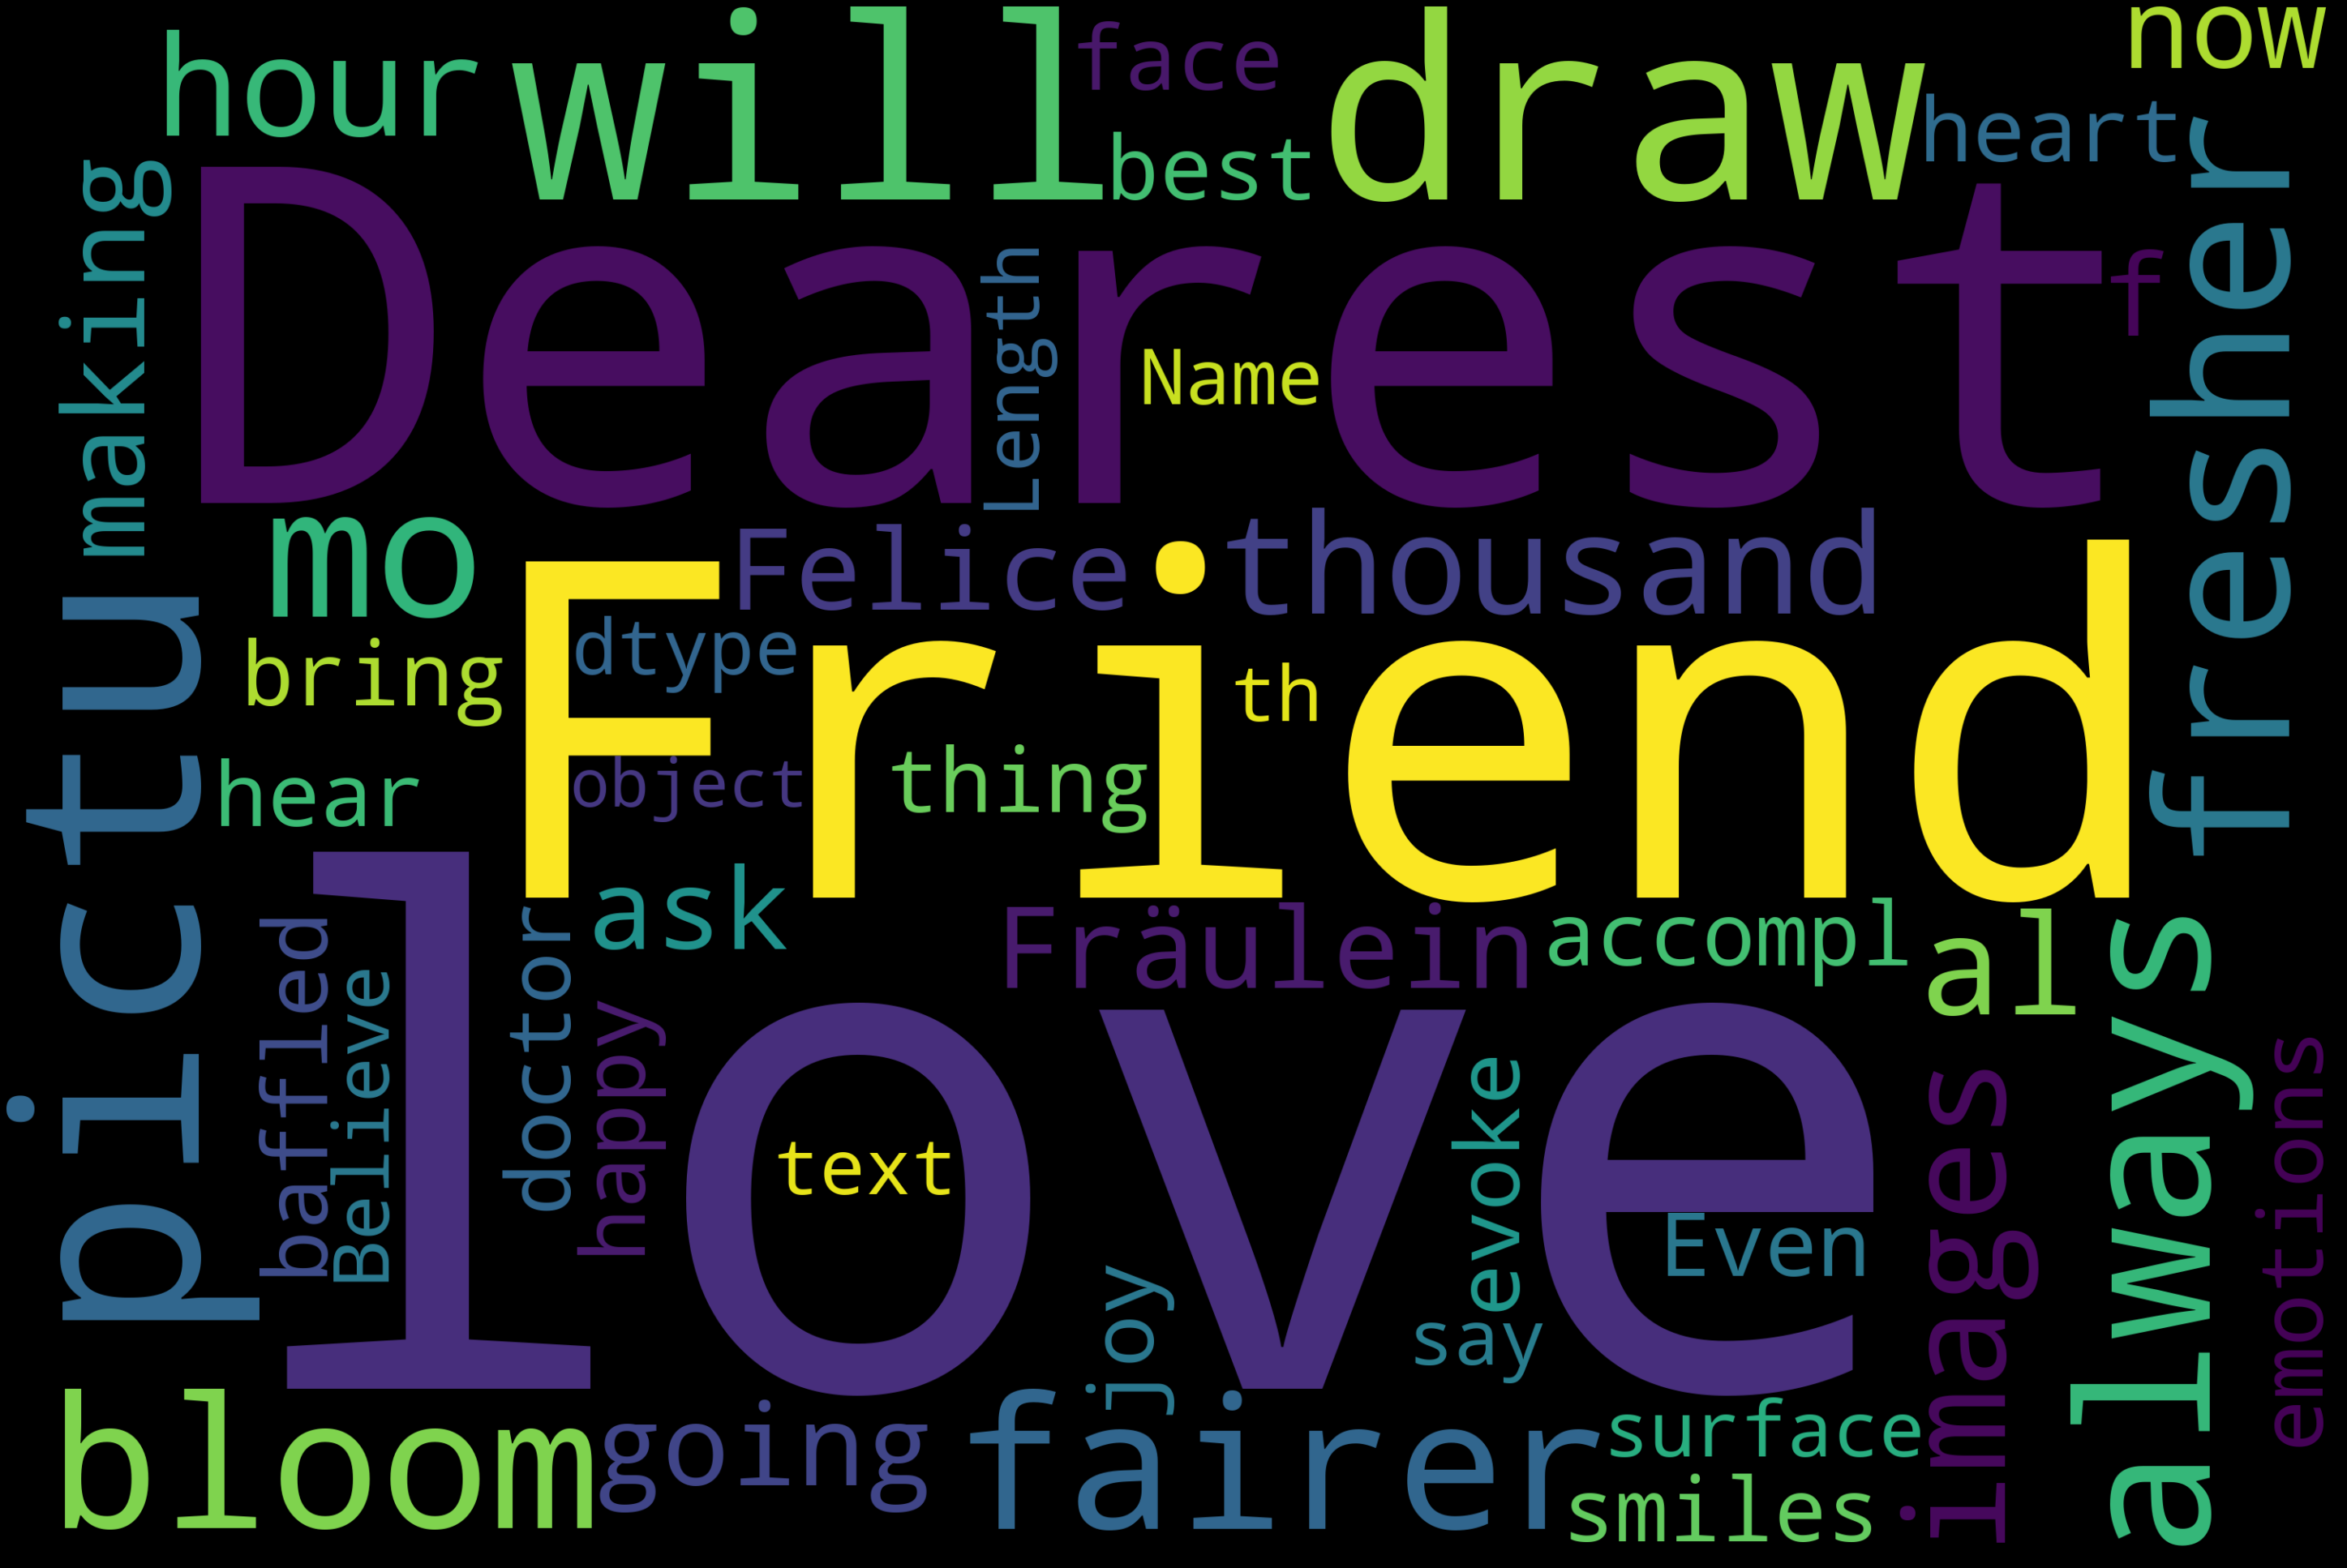

In [34]:
text = df_onlylove["text"]
wordcloud = WordCloud(width = 3000,height = 2000, background_color = 'black', stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(figsize = (40, 30), facecolor = 'k', edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

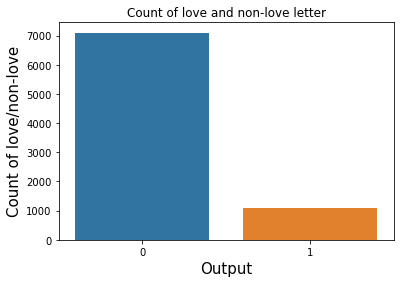

In [10]:
ax=sns.countplot(x="labels", data=clean_letter)

#Setting labels and font size
ax.set(xlabel='Output', ylabel='Count of love/non-love',title='Count of love and non-love letter')
ax.xaxis.get_label().set_fontsize(15)
ax.yaxis.get_label().set_fontsize(15)

C:\Users\Shin\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

C:\Users\Shin\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

C:\Users\Shin\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



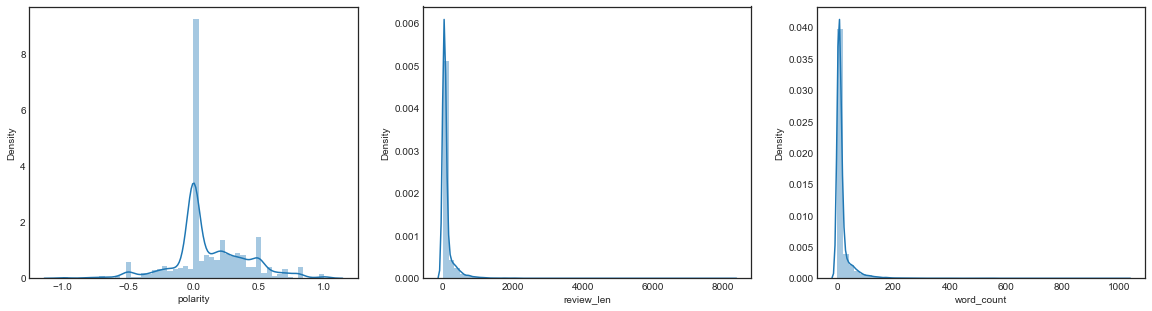

In [11]:
#Extracting the features from the news
clean_letter['polarity'] = clean_letter['text'].map(lambda text: TextBlob(text).sentiment.polarity)
clean_letter['review_len'] = clean_letter['text'].astype(str).apply(len)
clean_letter['word_count'] = clean_letter['text'].apply(lambda x: len(str(x).split()))

#Plotting the distribution of the extracted feature
plt.figure(figsize = (20, 5))
plt.style.use('seaborn-white')
plt.subplot(131)
sns.distplot(clean_letter['polarity'])
fig = plt.gcf()
plt.subplot(132)
sns.distplot(clean_letter['review_len'])
fig = plt.gcf()
plt.subplot(133)
sns.distplot(clean_letter['word_count'])
fig = plt.gcf()

In [17]:
#Function to get top n words
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

#Calling function and return only top 20 words
common_words = get_top_n_words(clean_letter['text'], 20)

#Printing the word and frequency
for word, freq in common_words:
    print(word, freq)

#Creating the dataframe of word and frequency
df = pd.DataFrame(common_words, columns = ['news' , 'count'])

#Group by words and plot the sum
df.groupby('news').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 words in letter')

love 3028
know 1559
like 1077
one 1047
want 1018
life 1001
im 969
dont 935
would 910
time 891
much 829
day 819
heart 795
never 780
think 767
feel 722
get 722
always 683
could 649
us 640


In [ ]:
text = fake_news["news"]
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [18]:
y = clean_letter.labels

In [19]:
X_train, X_test, y_train, y_test = train_test_split(clean_letter['text'],y,test_size=0.33,random_state=53)
count_vectorizer = CountVectorizer(stop_words='english')
count_train = count_vectorizer.fit_transform(X_train.values)
count_test = count_vectorizer.transform(X_test.values)

In [20]:
nb_classifier = MultinomialNB()
nb_classifier.fit(count_train,y_train)
pred = nb_classifier.predict(count_test)
metrics.accuracy_score(y_test,pred)

0.9571005917159763

In [35]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


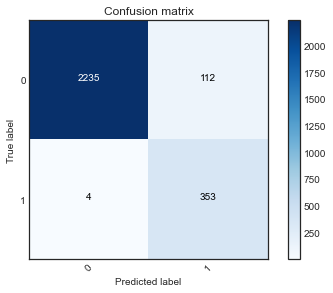

In [42]:
cm = metrics.confusion_matrix(y_test,pred,labels=[0,1])
plot_confusion_matrix(cm, classes=['0','1'])

In [22]:
test = "Najib is the best prime minister in the world"
test_series = pd.Series(test)
ct_test = count_vectorizer.transform(test_series)
result = nb_classifier.predict(ct_test)
if result == 1:
    print("Love")
else:
    print("Think too much")

Think too much
